# Maximizing Life Satisfaction by Applying Machine Learning to a Data Journal

- Author: Aaron Gillespie  
- Date: 2025-04-20

> [!tldr]
> A somewhat tongue-in-cheek project utilizing machine learning and business intelligence tools against **12 years of quantified self data** to determine, once and for all, what contributes to a satisfying life. Compiled for fun, but also as part of Northwest Missouri's CSIS 44670 Final. 

This repository is being created in service of Northwest Missouri State University 44608 Module 6 - Exploratory Data Analysis. It will accomplish the following objectives from the module:

- demonstrate skills with Jupyter, pandas, Seaborn and popular tools for data analytics
- utilize machine learning to develop predictive models
- tell a data story and visually present findings in a clear and engaging manner

And, in my case, will include one additional objective:
- Utilizing my long-running quantified self project / data journal for an grad school assignment

## About the Dataset

The data gathered for this work are from many sources. The primary data sources are: 

- my long-running [Data Journal](https://aarongilly.com/Pages/Data-Journal) project
- my Oura ring
- Apple Health & various other apps

The data all represent me & my life over the past 12 years. For the purposes of machine learning, the dataset will only reach back ~8 years, as I didn't start doing my daily "**Satisfaction**" score until June, 2017. 

> [!important] **Satisfaction** is the target we'll be training against  
> Each night I rate how satisfied I am with the day's happenings on a scale from 1 to 10.  
> 10 is a perfect day, 1 is reserved for the truly horrid days.

### The Data Journal - in short:

Data Journal is a system I built to help me keep track of stuff that happens in my life. Its form has changed greatly over the past decade, but its function has remained the same: to house data about things I do. It’s a default place to make note of things that might not otherwise have a place. I’ve tracked lots of different things over the years.

![data journal gist](assets/dj.png)

Building and maintaining a Data Journal is an easy and incredible habit to get into. I think everyone could benefit from having one of their own, tracking the things that are important to them.

For more on my Data Journal, read [this page on my personal site](https://aarongilly.com/Pages/Data-Journal).

## Section 0. Pre-work

The full version of this dataset contains a multitude of things I wouldn't want published online, so much scrubbing & pre-work was done *before* the creation of the `data/` folder.

Pre-work included sourcing data from various apps, fed by various pieces of hardware over the past decade.

![work already done](assets/pre-work.png)

The full dataset would include things like daily summaries, details about where I've gone, who I've spent time with, etc. None of those data features are present in this public-facing dataset. Thus those factors will not be considered in this model.

While I was doing this sanitization - to facilitate the machine learning model I converted **categorical** data to **numeric** data using a form of **one-hot** encoding. For example, I converted an `exercise type` column into three separate columns for each exercise type I track.

This was done by hand, and it isn't *techincally* "one" hot. For example, I could run & lift weights on the same day, which would translate to `1` in both the `Strength` and `Cardio` columns.

## Section 1. Import and Inspect the Data

Before we can do any machine learning, we have to obtain references to the data in code.

In [1]:
# Imports.

import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Path to the data folder
data_folder = 'data/'

# Dictionary to store dataframes
dataframes = {}

# Read each CSV file into its own dataframe
for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        df_name = file.split('.')[0]  # Use the file name (without extension) as the dataframe name
        dataframes[df_name] = pd.read_csv(file_path)

# Display the names of the dataframes loaded
print(f"Loaded dataframes: {list(dataframes.keys())}")



Loaded dataframes: ['Diet', 'VO2', 'Oura', 'Hevy', 'Cardio', 'Data_Journal']


In [3]:
# Process each dataframe to conform headers to snake_case and convert the first column to datetime
for name, df in dataframes.items():
    # Convert headers to lowercase snake_case
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
    
    # Convert the first column to datetime
    first_column = df.columns[0]
    df[first_column] = pd.to_datetime(df[first_column])
    
    # Update the dataframe in the dictionary
    dataframes[name] = df

# Display the updated headers for verification
for name, df in dataframes.items():
    print(f"{name} headers: {df.columns.tolist()}")

Diet headers: ['date', 'breakfast_calories', 'breakfast_carbs', 'breakfast_fats', 'breakfast_protein', 'lunch_calories', 'lunch_carbs', 'lunch_fats', 'lunch_protein', 'dinner_calories', 'dinner_carbs', 'dinner_fats', 'dinner_protein', 'snacks_calories', 'snacks_carbs', 'snacks_fats', 'snacks_protein', 'calories', 'carbs', 'fats', 'protein']
VO2 headers: ['date', 'vo2_est']
Oura headers: ['date', 'active_calories', 'sedentary_time', 'steps', 'activity_score', 'readiness_score', 'sleep_score', 'temperature_deviation', 'average_breath', 'average_heart_rate', 'average_hrv', 'awake_time', 'deep_sleep_duration', 'efficiency', 'latency', 'light_sleep_duration', 'rem_sleep_duration', 'time_in_bed', 'total_sleep_duration']
Hevy headers: ['date', 'lift_volume_lbs']
Cardio headers: ['date', 'activitytype', 'duration', 'cals_burned', 'meters']
Data_Journal headers: ['date', 'wk_day', 'day', 'week', 'month', 'quarter', 'year', 'travel', 'satisfaction', 'health', 'work_status', 'bedtime', 'wake', 's

/var/folders/hk/h6rz0nm939n_y0ssynfrg63r0000gn/T/ipykernel_10982/2360739851.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[first_column] = pd.to_datetime(df[first_column])


In [4]:
# Check for missing values and display summary statistics for each dataframe
for name, df in dataframes.items():
    print(f"Summary for dataframe: {name}")
    missingCounts = df.isnull().sum()
    if (missingCounts > 0).any():
        print(f"Missing values in {name}:")
        print(missingCounts[missingCounts > 0])
    print("\nSummary statistics:")
    print(df.describe(include='all'))
    print("\n" + "-"*50 + "\n")

Summary for dataframe: Diet

Summary statistics:
                      date  breakfast_calories  breakfast_carbs  \
count                  144          144.000000       144.000000   
mean   2019-05-20 06:50:00          360.792361        23.260417   
min    2018-11-06 00:00:00            0.000000         0.000000   
25%    2019-02-05 00:00:00            0.000000         0.000000   
50%    2019-05-15 12:00:00          220.000000         0.000000   
75%    2019-08-19 18:00:00          637.225000        27.500000   
max    2020-01-28 00:00:00         2050.000000       301.000000   
std                    NaN          443.120202        48.328059   

       breakfast_fats  breakfast_protein  lunch_calories  lunch_carbs  \
count      144.000000         144.000000      144.000000   144.000000   
mean        31.331944          39.181944      645.668056    40.559722   
min          0.000000           0.000000        0.000000     0.000000   
25%          9.450000          14.000000        0.00000

### Reflection 1:

**What do you notice about the dataset?**

This is very much "my" dataset. I'm incredibly familiar with it. Right now I notice it's spread out amongst many data frames, which won't be helpful. Need to resolve that.

**Are there any data issues?**

There are some issues I'll address soon. Things that contain a `0.0` that should contain a `NaN` or blank value, for one. 

## Section 2. Data Exploration and Preparation

In this section we explore the data a bit further, consider how we might modify it to make the machine learning process go easier and/or produce better results, and then make those modifications. We will add some features to this dataset to give each row a "memory" of the row(s) before it, as I strongly suspect my subjective "daily satisfaction" is actually a cumulative result of the recent past few days, not just the day that receives the grade.

In [5]:
# Start with the first dataframe in the dictionary
combined_df = dataframes['Diet']

# Merge all other dataframes into the combined dataframe on the "date" column
for key, df in dataframes.items():
    if key != 'Diet':  # Skip the first dataframe as it's already included
        combined_df = combined_df.merge(df, on='date', how='outer')

# Display the combined dataframe's info and a preview
print(combined_df.info())
print(combined_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   3006 non-null   datetime64[ns]
 1   breakfast_calories     144 non-null    float64       
 2   breakfast_carbs        144 non-null    float64       
 3   breakfast_fats         144 non-null    float64       
 4   breakfast_protein      144 non-null    float64       
 5   lunch_calories         144 non-null    float64       
 6   lunch_carbs            144 non-null    float64       
 7   lunch_fats             144 non-null    float64       
 8   lunch_protein          144 non-null    float64       
 9   dinner_calories        144 non-null    float64       
 10  dinner_carbs           144 non-null    float64       
 11  dinner_fats            144 non-null    float64       
 12  dinner_protein         144 non-null    float64       
 13  sna

The data look good here, but given the importance of this combined dataframe for the rest of the project, I'm going to export the newly joined toegether dataset to a csv to inspect it in Excel.

In [6]:
# Export to an output_data folder for inspection in Excel

combined_df.to_csv('output_data/combined_data.csv', index=False)

Merging the data together populated some rows for those few days wherein I failed to give myself a daily "Satisfaction" rating. This will be the target of our machine learning, so we can drop those rows.

In [7]:
# Remove rows where the 'satisfaction' column contains no value
combined_df = combined_df.dropna(subset=['satisfaction'])

# Display the updated dataframe info
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2874 entries, 0 to 3005
Data columns (total 77 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   2874 non-null   datetime64[ns]
 1   breakfast_calories     143 non-null    float64       
 2   breakfast_carbs        143 non-null    float64       
 3   breakfast_fats         143 non-null    float64       
 4   breakfast_protein      143 non-null    float64       
 5   lunch_calories         143 non-null    float64       
 6   lunch_carbs            143 non-null    float64       
 7   lunch_fats             143 non-null    float64       
 8   lunch_protein          143 non-null    float64       
 9   dinner_calories        143 non-null    float64       
 10  dinner_carbs           143 non-null    float64       
 11  dinner_fats            143 non-null    float64       
 12  dinner_protein         143 non-null    float64       
 13  snacks_c

Add some features based on factors that "feel" like things that might effect the subjective rating I'd give a day.

In [8]:
# Add a running average column for satisfaction over the previous 3 rows
combined_df['satisfaction_running_avg'] = combined_df['satisfaction'].rolling(window=3, min_periods=1).mean()

# Adding a workouts column that reports if any of the workouts were done
combined_df['workouts'] = combined_df[['strength', 'cardio', 'mobility']].sum(axis=1)

# Add a column to count successive zeros in the workouts column
combined_df['days_since_workout'] = combined_df['workouts'].eq(0).astype(int).groupby(combined_df['workouts'].ne(0).cumsum()).cumsum()

# Display the first few rows to verify
print(combined_df[['date', 'satisfaction', 'satisfaction_running_avg']].head(10))
print(combined_df[['date', 'strength', 'cardio', 'mobility', 'workouts']].head(10))
print(combined_df[['date', 'workouts', 'days_since_workout']].head(30))

        date  satisfaction  satisfaction_running_avg
0 2017-06-10           4.0                  4.000000
1 2017-06-11           7.0                  5.500000
2 2017-06-12           7.0                  6.000000
3 2017-06-13           7.0                  7.000000
4 2017-06-14           8.0                  7.333333
5 2017-06-15           4.0                  6.333333
6 2017-06-16           9.0                  7.000000
7 2017-06-17          10.0                  7.666667
8 2017-06-18           8.0                  9.000000
9 2017-06-19           7.0                  8.333333
        date  strength  cardio  mobility  workouts
0 2017-06-10       0.0     1.0       0.0       1.0
1 2017-06-11       0.0     1.0       0.0       1.0
2 2017-06-12       0.0     0.0       0.0       0.0
3 2017-06-13       0.0     0.0       0.0       0.0
4 2017-06-14       0.0     0.0       0.0       0.0
5 2017-06-15       0.0     0.0       0.0       0.0
6 2017-06-16       0.0     0.0       0.0       0.0
7 2017-06

We have an issue wherein some columns contain `0.0` where there should actually be a `null` or `NaN` value before I started tracking them. For example - the `ate_out`, `date_night`, and columns near that were tracked only since 2020. All data before that report a `0.0`, but they should just be *blank*. This is a case wherein I need to a correction to align with one of my system-design prinicples: 

> [Don't use absence of a signal as a signal](https://gillespedia.com/Don%E2%80%99t+use+%E2%80%9CAbsence+of+a+Signal%E2%80%9D+as+a+Signal)

In [9]:
# Replace values with NaN for "outings" and "pains/treatments" rows where the date is before 2020-01-01
columns_to_update = ['date_night', 'ate_out', 'saw_family', 'saw_friends', 'pains', 'treatments']
combined_df.loc[combined_df['date'] < '2020-01-01', columns_to_update] = None

# Replace values with NaN for "media" rows where the date is before 2019-01-01
columns_to_update = ['book', 'tv', 'videogame', 'movie']
combined_df.loc[combined_df['date'] < '2019-01-01', columns_to_update] = None

We'll do one more sanity check export to CSV to check everything before we move on to the machine learning portion.

In [10]:
# Export to an output_data folder for inspection in Excel

combined_df.to_csv('output_data/combined_data_with_features.csv', index=False)

After reviewing that, all's well for the most part. Now I'm going to produce some pretty visuals to give you, dear reader, some ideas of what's in here.

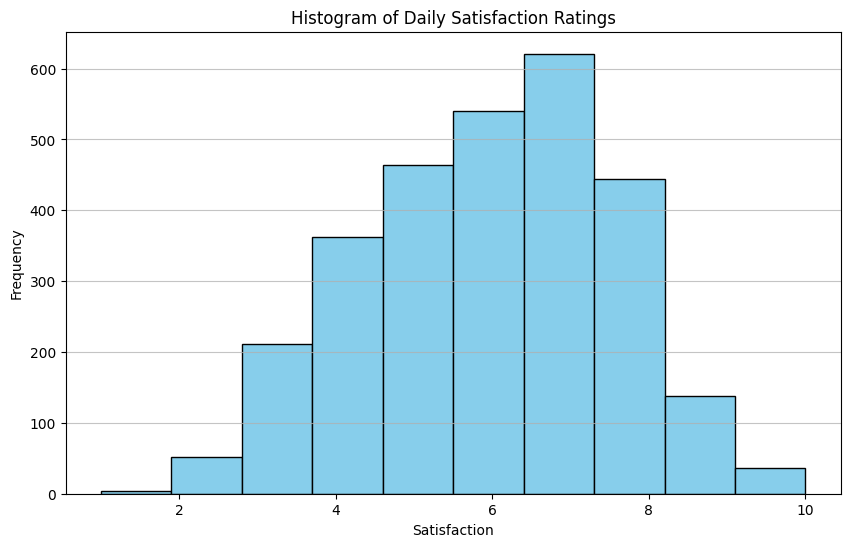

In [11]:
# Create a histogram of the 'satisfaction' column
plt.figure(figsize=(10, 6))
plt.hist(combined_df['satisfaction'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Daily Satisfaction Ratings')
plt.xlabel('Satisfaction')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

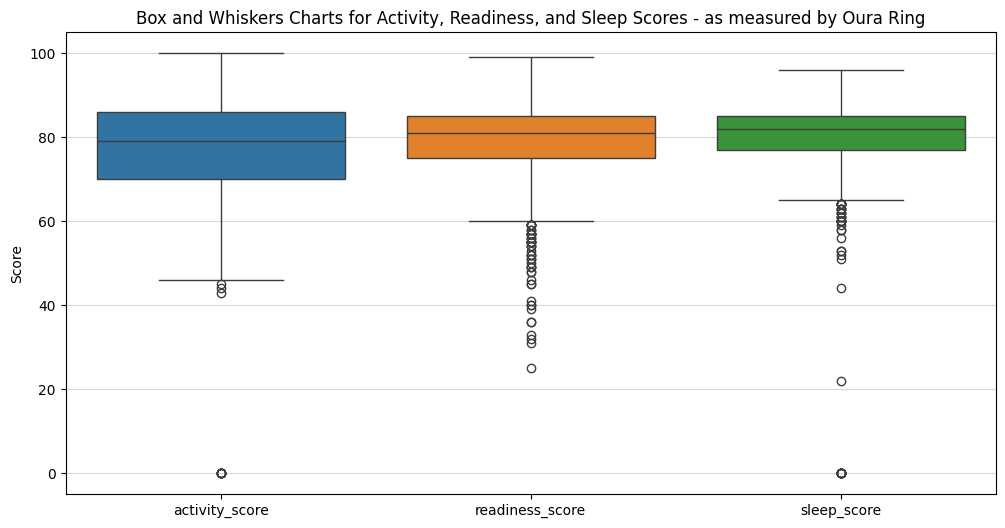

In [12]:
# Create box and whiskers charts for the specified columns
columns_to_plot = ['activity_score', 'readiness_score', 'sleep_score']

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df[columns_to_plot])
plt.title('Box and Whiskers Charts for Activity, Readiness, and Sleep Scores - as measured by Oura Ring')
plt.ylabel('Score')
plt.xticks(ticks=range(len(columns_to_plot)), labels=columns_to_plot)
plt.grid(axis='y', alpha=0.5)
plt.show()

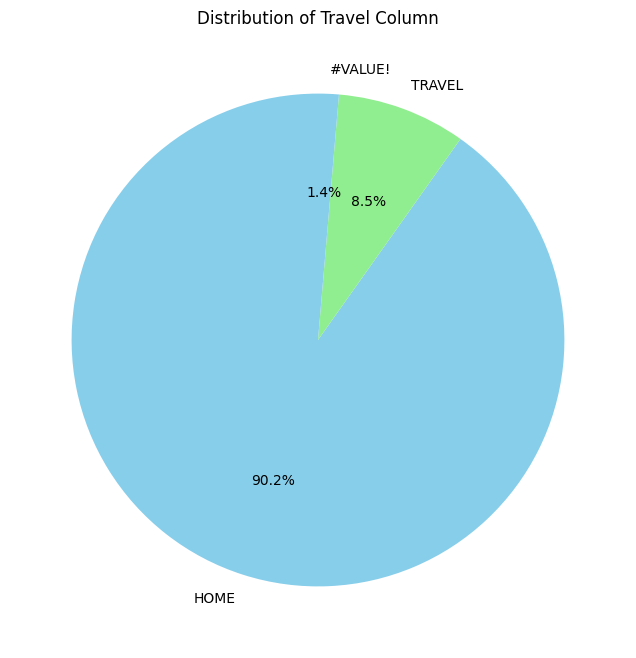

In [13]:
# Count the occurrences of each value in the 'travel' column
travel_counts = combined_df['travel'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(travel_counts, labels=travel_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Travel Column')
plt.show()

Ooo found some bad data there. Replacing the `#VALUE!# with blanks.

In [14]:
# Replace '#VALUE!' in the 'travel' column with blank values (NaN)
combined_df['travel'] = combined_df['travel'].replace('#VALUE!', None)

# Verify the replacement
print(combined_df['travel'].value_counts(dropna=False))

travel
HOME      2592
TRAVEL     243
None        39
Name: count, dtype: int64


In [ ]:
# Columns to plot
sleep_columns = ['deep_sleep_duration', 'light_sleep_duration', 'rem_sleep_duration']

# Create box and whisker charts
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df[sleep_columns])
plt.title('Box and Whisker Charts for Sleep Durations')
plt.ylabel('Duration (minutes)')
plt.xticks(ticks=range(len(sleep_columns)), labels=sleep_columns)
plt.grid(axis='y', alpha=0.5)
plt.show()

### Reflection 2: 

**What patterns or anomalies do you see?**

I've noticed a few anomalies, which were corrected above. Some columns with zeroes where there should have been blanks. The newly added feature "days_since_workout" flagged one streak of 50 days where I didn't record a workout, which I didn't believe. Looking at the source data more, I think there are definitely workouts in there, but they were not actually tracked. That timespan coincides with a source code change that likely caused some issues in capture for a period of time. 

**Do any features stand out?**

Lots stand out. It's easier for me ot say the ones I expect are not that useful - my per-meal-type, per-macronutrient caloric breakdown is... almost certainly not affecting my satisfaction. If there were a correlation there I'd expect it to be reverse-causal. Low satisfaction leading to the urge to snack. 

**What preprocessing steps were necessary to clean and improve the data?** 

Lots. See the steps above.

**Did you create or modify any features to improve performance?**

I did create features based on what I expect should be correlated with satisfaction. I also did some minor modifications to fix data issues here and there. Much of the *real* work was done before the data ever got into this repository when I scrubbed out the things I didn't feel like sharing.


## Section 3. Feature Selection and Justification


## Section 4. Train a Model (Linear Regression)


## Section 5. Improve the Model or Try Alternatives (Implement Pipelines)

## Section 6. Final Thoughts & Insights



### Future Work - Extensions

While my dataset is extensive, it's missing all sorts of things I'd *like* for it to have. 

- **Diet** - While I **do** have some calories and macronutriet data, I do not have many factors relevant to a healthy life, such as the level of processing that went into the food
- **Biomarkers** - in particular blood sugar from a continuous glucose monitor
- **Photos** - I'd like to run all my photos through a classification model & have data about the contents of said photos, who am I taking photos of, what settings, etc
- **Natural Language Processing** - this is full down-the-rabbit-hole territory, but it would be neat to see sentiments pulled from [my personal blog](https://aarongilly.com), the volume of [my public-facing notes](https://gillespedia.com), etc.